In [1]:
import os
import warnings
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import healpy as hp
from astropy.time import Time

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.data import get_data_dir

from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel
from rubin_scheduler.site_models import ConstantSeeingData, ConstantWindData

from rubin_scheduler.utils import ra_dec2_hpid
from rubin_scheduler.scheduler.utils import empty_observation

from rubin_scheduler.scheduler import basis_functions
from rubin_scheduler.scheduler import features
from rubin_scheduler.scheduler.detailers import CameraSmallRotPerObservationListDetailer
from rubin_scheduler.scheduler.surveys import FieldSurvey
from rubin_scheduler.scheduler.schedulers import CoreScheduler, ComCamFilterSched
from rubin_scheduler.utils import Site, _approx_altaz2pa, pseudo_parallactic_angle, rotation_converter

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.utils import SchemaConverter

In [2]:
at_usdf = False
if at_usdf:
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/group/rubin/shared/rubin_sim_data"
print("Using rubin_sim_data from ", get_data_dir())

Using rubin_sim_data from  /Users/lynnej/rubin_sim_data


In [3]:
# Setting the start of the *survey* (and keeping this the same) is important for the Model Observatory and Scheduler,
# because this sets an overall dither pattern per night, but also helps track things that may 
# otherwise change per night ... for SV surveys, might not be totally necessary, but is good practice
# (you can change the *day* / mjd that you are simulating, of course, but mjd_start should remain the same)

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')

In [4]:
# Don't have to do this, but can grab almanac information

almanac = Almanac(mjd_start = survey_start.mjd)

def show_almanac_info(dayobs):
    night_info = almanac.get_sunset_info(evening_date=dayobs, longitude=Site('LSST').longitude_rad)
    
    dd = []
    for val, col in zip(night_info, night_info.dtype.names):
        if col == 'night':
            continue
        else:
            print(col, val, Time(val, format='mjd', scale='utc').iso)
    
    # And can check on the lunar phase -- this goes from 0 (new) to 100 (full)
    moon_phase = almanac.get_sun_moon_positions(night_info['moonrise'])['moon_phase']
    print(f'moonphase(%) {moon_phase.round(2)}')

show_almanac_info(dayobs)

sunset 60562.936555093154 2024-09-09 22:28:38.360
sun_n12_setting 60562.975207073614 2024-09-09 23:24:17.891
sun_n18_setting 60562.99454106344 2024-09-09 23:52:08.348
sun_n18_rising 60563.39397472935 2024-09-10 09:27:19.417
sun_n12_rising 60563.4132887749 2024-09-10 09:55:08.150
sunrise 60563.45188789442 2024-09-10 10:50:43.114
moonrise 60563.62073250674 2024-09-10 14:53:51.289
moonset 60563.19181374041 2024-09-10 04:36:12.707
moonphase(%) 46.25


In [5]:
def tma_movement(percent=70):
    # See https://confluence.lsstcorp.org/display/LSSTCOM/TMA+Motion+Settings
    # Expected performance at end of comcam on-sky is probably 10%
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    tma = {}
    scale = percent / 100.0
    tma['azimuth_maxspeed'] = np.min([10.0 * scale, 7.0])
    tma['azimuth_accel'] = 10.0 * scale
    tma['azimuth_jerk'] = np.max([1.0, 40.0 * scale])
    tma['altitude_maxspeed'] = 5.0 * scale
    tma['altitude_accel'] = 5.0 * scale
    tma['altitude_jerk'] = np.max([1.0, 20.0 * scale])
    tma['settle_time'] = 3.0
    return tma

In [6]:
def rotator_movement(percent=100):
    # Kevin and Brian say these can run 100% and are independent of TMA movement
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    rot = {}
    rot['maxspeed'] = 3.5 * percent/100
    rot['accel'] = 1.0 * percent/100
    rot['jerk'] = 4.0 * percent/100
    return rot

In [7]:
## field survey to be tested .. this should make it unnecessary to specify particular notes in features for basis functions.
# See examples of key basis functions .. you can call basis_function.__calc_rewards(conditions) to see what the basis function values look like.sv

In [8]:
def get_sv_fields():
    fields = (
        ("Rubin_SV_095_-25", 95., -25.), # High stellar densty, low extinction
        ("Rubin_SV_125_-15", 125., -15.), # High stellar densty, low extinction
        ("DESI_SV3_R1", 179.60, 0.000), # DESI, GAMA, HSC DR2, KiDS-N
        ("Rubin_SV_225_-40", 225., -40.), # 225 High stellar densty, low extinction
        ("DEEP_A0", 216, -12.5), # DEEP Solar Systen
        ("Rubin_SV_250_2", 250., 2.), # 250 High stellar densty, low extinction
        ("Rubin_SV_300_-41", 300., -41.), # High stellar densty, low extinction 
        ("Rubin_SV_280_-48", 280., -48.), # High stellar densty, low extinction 
        ("DEEP_B0", 310, -19), # DEEP Solar System
        ("ELAIS_S1", 9.45, -44.0), # ELAIS-S1 LSST DDF
        ("XMM_LSS", 35.708333, -4.75), # LSST DDF
        ("ECDFS", 53.125, -28.1), # ECDFS
        ("COSMOS", 150.1, 2.1819444444444445), # COSMOS
        ("EDFS_A", 58.9, -49.315), # EDFS_a
        ("EDFS_B", 63.6, -47.6), # EDFS_b
    )
    
    fields_dict = dict(zip([f[0] for f in fields], [{'RA': f[1], 'Dec': f[2]} for f in fields]))
    return fields_dict


def get_basis_functions_field_survey(
    nside: int = 32,
    wind_speed_maximum: float = 10,
) -> list[basis_functions.BaseBasisFunction]:
    """Get the basis functions for a field survey.

    Parameters
    ----------
    nside : `int`
        The nside value for the healpix grid.
    wind_speed_maximum : `float`
        Maximum wind speed tolerated for the observations of the survey,
        in m/s.

    Returns
    -------
    `list` of `basis_functions.BaseBasisFunction`
    """
    sun_alt_limit = -12.0
    moon_distance = 30

    bfs = [
        basis_functions.NotTwilightBasisFunction(sun_alt_limit=sun_alt_limit),
        basis_functions.MoonAvoidanceBasisFunction(nside=nside, moon_distance=moon_distance),
        basis_functions.AvoidDirectWind(
            wind_speed_maximum=wind_speed_maximum, nside=nside
        ),
        # Mask parts of the sky in alt/az, including parts of the sky that will move into this area
        # (replaces azimuth mask and zenith shadow mask, should also be able to replace airmass basis function)
        basis_functions.AltAzShadowMaskBasisFunction(
            nside=nside, min_alt=22, max_alt=83, min_az=0.0, max_az=360.0, shadow_minutes=30
        ),
        # Avoid revisits within 30 minutes -- sequence is about 60 minutes long, don't repeat immediately
        basis_functions.AvoidFastRevisitsBasisFunction(nside=nside, filtername=None, gap_min=30.0),
        # reward fields which are rising, but don't mask out after zenith
        basis_functions.RewardRisingBasisFunction(nside=nside, slope=0.1, penalty_val=0),
        # Reward parts of the sky which are darker -- note that this is only for r band, so relying on
        # skymap in r band .. if there isn't a strong reason to go with the darkest pointing,
        # it might be reasonable to just drop this basis function
        basis_functions.M5DiffBasisFunction(filtername='r', nside=nside),
    ]
    return bfs

def get_field_survey(field_ra_deg, field_dec_deg, field_name, basis_functions, detailers, nside=32):
    
    field_survey = FieldSurvey(basis_functions, 
                                   field_ra_deg,
                                    field_dec_deg,
                                    sequence='ugrizy',
                                    nvisits={'u': 20, 'g': 20, 'r': 20, 'i': 20, 'z': 20, 'y': 20},
                                    exptimes={'u': 38, 'g': 30, 'r': 30, 'i': 30, 'z': 30, 'y': 30},
                                    nexps={'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2},
                                    ignore_obs=None,
                                    accept_obs=[field_name],
                                    survey_name=field_name,
                                    scheduler_note=None,
                                    readtime=2.4,
                                    filter_change_time=120.0,
                                    nside=nside,
                                    flush_pad=30.0,
                                    detailers=detailers)
    return field_survey

In [9]:
def prioritize_fields(priority_field_list=None, other_field_list=None):
    field_dict = get_sv_fields()
    tier1 = []
    if priority_field_list is not None:
        for f in priority_field_list:
            # Remember field name and remove from list
            if f in field_dict:
                tier1.append(f)
                del field_dict[f]
    tier2 = []
    if other_field_list is not None:
        for f in other_field_list:
            if f in field_dict:
                tier2.append(f)
                del field_dict[f]
    else:
        tier2 += list(field_dict.keys())
    return [tier1, tier2]


tiers = prioritize_fields() #prioritize_fields(['Rubin_SV_280_-48'], None)

print(tiers)

[[], ['Rubin_SV_095_-25', 'Rubin_SV_125_-15', 'DESI_SV3_R1', 'Rubin_SV_225_-40', 'DEEP_A0', 'Rubin_SV_250_2', 'Rubin_SV_300_-41', 'Rubin_SV_280_-48', 'DEEP_B0', 'ELAIS_S1', 'XMM_LSS', 'ECDFS', 'COSMOS', 'EDFS_A', 'EDFS_B']]


In [10]:
def get_model_observatory(dayobs='2024-09-09'):
    # Set up a fresh model observatory
    survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
    mjd_now = survey_start.mjd

    kinematic_model = KinemModel(mjd0=mjd_now)
    kinematic_model.setup_camera(readtime=2.4, **rotator_movement(100.))
    kinematic_model.setup_telescope(**tma_movement(10.0))
    
    # Some weather telemetry that might be useful
    seeing_data = ConstantSeeingData(fwhm_500=2.0)
    wind_data = ConstantWindData(wind_direction=340, wind_speed=5.0)
    
    # Set up the model observatory
    observatory = ModelObservatory(mjd=mjd_now, 
                                   mjd_start=survey_start.mjd,
                                   kinem_model=kinematic_model, # Modified kinematics
                                   cloud_data='ideal',          # No clouds
                                   seeing_data=seeing_data,     # Modified seeing
                                   wind_data=wind_data,         # Add some wind
                                   downtimes='ideal',           # No downtime
                                   lax_dome=True,               # dome crawl?
                                   init_load_length=1,          # size of skybrightness files to load first
                                  )
    return observatory

def get_comcam_schedulers(tiers=None):
    # Set up again to be sure all is 'clean'
    field_dict = get_sv_fields()
    if tiers is None:
        tiers = prioritize_fields() 
    
    surveys = []
    starting_tier = 0
    i = 0
    for t in tiers:
        if len(t) == 0:
            continue
        j = i + starting_tier
        i += 1
        surveys.append([])
        for kk, fieldname in enumerate(t):
            bfs = get_basis_functions_field_survey()
            detailer = CameraSmallRotPerObservationListDetailer(per_visit_rot=0.5)
            surveys[j].append(get_field_survey(field_dict[fieldname]['RA'], field_dict[fieldname]['Dec'], fieldname, bfs, [detailer]))
    surveys
    
    scheduler = CoreScheduler(surveys, nside=32)
    filter_scheduler = ComCamFilterSched()
    return scheduler, filter_scheduler


def update_model_observatory_sunset(observatory, filter_scheduler):
    # Make sure correct filters are mounted
    conditions = observatory.return_conditions()
    filters_needed = filter_scheduler(conditions)
    observatory.observatory.mount_filters(filters_needed)
    conditions = observatory.return_conditions()
    print("Current filter set", conditions.mounted_filters)
    
    # Move ahead to twilight
    observatory.mjd = conditions.sun_n18_setting
    print("Current observatory time", observatory.mjd)
    return observatory

In [11]:
verbose = False

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
mjd_now = survey_start.mjd

# Set up again to be sure all is 'clean'
scheduler, filter_scheduler = get_comcam_schedulers()
observatory = get_model_observatory(dayobs)
observatory = update_model_observatory_sunset(observatory, filter_scheduler)
conditions = observatory.return_conditions()

mjd = observatory.mjd
mjd_end = conditions.sun_n12_rising
survey_length = 30 #mjd_end - mjd

observatory, scheduler, observations = sim_runner(observatory,
                                                scheduler,
                                                filter_scheduler=filter_scheduler,
                                                mjd_start=mjd,
                                                survey_length=survey_length,
                                                n_visit_limit=None,
                                                step_none=10.0,
                                                verbose=True,
                                                record_rewards=False,
                                                start_result_size=int(2e4),
                                                append_result_size=int(2.5e4),
                                            )

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:289: RuntimeWarning: All-NaN axis encountered
  rewards[i] = np.nanmax(survey.calc_reward_function(self.conditions))


Current filter set ['g', 'r', 'i']
Current observatory time 60562.99454106344
progress = 10.36%

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:291: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(rewards) > -np.inf:
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:294: RuntimeWarning: All-NaN slice encountered
  if (np.nanmax(rewards) == -np.inf) | (np.isnan(np.nanmax(rewards))):
Failed to fill queue at time [60566.12452833]
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:115: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60566.13147277]
Failed to fill queue at time [60566.13841722]


progress = 13.55%

Failed to fill queue at time [60567.06578078]
Failed to fill queue at time [60567.07272522]
Failed to fill queue at time [60567.07966967]


progress = 13.69%

Failed to fill queue at time [60567.11719434]
Failed to fill queue at time [60567.12413878]
Failed to fill queue at time [60567.13108323]


progress = 99.98%Skipped 9 observations
Flushed 0 observations from queue for being stale
Completed 24795 observations
ran in 1 min = 0.0 hours


In [12]:
sc = SchemaConverter()
visits = sc.obs2opsim(observations)

In [13]:
# Let's check in on sequences, because there are some issues
visits.groupby('target')['observationStartMJD'].count()

target
DEEP_B0             1920
ECDFS               1201
EDFS_A              6120
EDFS_B              5572
ELAIS_S1            5470
Rubin_SV_125_-15      69
Rubin_SV_225_-40     120
Rubin_SV_250_2      1159
Rubin_SV_280_-48     180
Rubin_SV_300_-41     900
XMM_LSS             2084
Name: observationStartMJD, dtype: int64

In [14]:
# How many observations per target, and are sequences completing? 
targets = visits.target.values
prev_target = np.concatenate([np.array([targets[0]], dtype=object), targets[0:-1]])
visits['prev_target'] = prev_target

change_sequences = np.where(visits.prev_target != visits.target)[0]
seq = pd.DataFrame(list(zip(change_sequences, np.diff(change_sequences))), columns=['ObservationID', 'seq_length'])
seq.query('seq_length != 60')

,ObservationID,seq_length
12,780,55
27,1675,38
31,1893,56
42,2549,35
46,2764,53
47,2817,120
55,3357,57
58,3534,180
67,4194,7
82,5041,24


In [15]:
# the time from the start of one exposure to the start of the next exposure:
slew_to_next_visit = visits['slewTime'][1:]
expected_overheads = visits['visitTime'][:-1].values + slew_to_next_visit.values
# Compare to the actual time between visits
actual_overheads = np.diff(visits['observationStartMJD'])*24*60*60 
# We can look at the difference to identify gaps in visits (seconds)
diff = np.abs(expected_overheads - actual_overheads)
indx = np.where((diff > 1) & (diff < 6*60*60))[0]
breaks = []
for i in indx:
    b1 = visits.iloc[i]['observationStartMJD']
    b2 = visits.iloc[i+1]['observationStartMJD']
    breaks.append([b1, b2])
print(indx)
print(breaks)

[2876 3593 3653]
[[60566.124130181226, 60566.14728855362], [60567.06538263201, 60567.08851129665], [60567.116796191105, 60567.13994836149]]


In [34]:
plt.figure(figsize=(8, 6))
filtershapes = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
filtercolors = {'u': '#005BDB',
                'g': '#3DA952',
                'r': '#c61c00',
                'i': '#997500',
                'z': '#CE0D77',
                'y': '#5d0000'}
fieldcolors = {}
for i, t in enumerate(visits.target.unique()):
    fieldcolors[t] = cc.glasbey[i]

if len(breaks) > 0:
    for b in breaks:
        plt.fill_between(b, 2.5, 0.0, color='pink', alpha=0.3)

night = 15
nvisits = visits.query('night == @night')
for t in nvisits.target.unique():
    vv = nvisits.query('target == @t')
    for f in vv['filter'].unique():
        vvf = vv.query('filter == @f')
        label = f'{t} {f}'
        plt.plot(vvf.observationStartMJD, vvf.airmass, linestyle='', 
                 marker=filtershapes[f], markersize=3, color=fieldcolors[t], label=label)
plt.legend(loc=(0.00 , -0.3), ncols=len(nvisits.target.unique()))
plt.ylim(2.5, 0.9)
plt.xlim(nvisits.observationStartMJD.min(), nvisits.observationStartMJD.max())
plt.grid(alpha=0.3)
plt.xlabel("MJD", fontsize='large')
plt.ylabel("Airmass", fontsize='x-large')
plt.title(f"Night {night}, {Time(nights.observationStartMJD.min(), format='mjd', scale='utc').isot.split("T")[0]}")

SyntaxError: f-string: unmatched '(' (3453135337.py, line 32)

In [17]:
# So what's up with the short sequences,and also breaks?
# almost certainly, it's a sequence which is not actually observable after the first visit .. 
# Find visit number, return observatory and scheduler to that state, and see. 

# If adding observations from previous nights, it's safe to use scheduler.add_observation(obs) in a loop over those observations
# But for observations within the current night, the model observatory needs us to run forward in time to ensure it's in the same state.

In [18]:
# Set up again to be sure all is 'clean' -- can do this if we want to stop at a particular nvisit during the night.
scheduler, filter_scheduler = get_comcam_schedulers()
observatory = get_model_observatory(dayobs)
# If we want to add previous night's observations, this is safe
# for obs in reload_observations:
#  scheduler.add_observation(obs)
#  observatory.mjd = obs['mjd'] + 0.5
observatory = update_model_observatory_sunset(observatory, filter_scheduler)

conditions = observatory.return_conditions()
mjd = observatory.mjd
mjd_end = conditions.sun_n12_rising
survey_length = mjd_end - mjd

# But for observations within this night - run up to the time in question like this: 
nvisits = 121

observatory, scheduler, observations = sim_runner(observatory,
                                                scheduler,
                                                filter_scheduler=filter_scheduler,
                                                mjd_start=mjd,
                                                survey_length=survey_length,
                                                n_visit_limit=nvisits,
                                                step_none=10.0,
                                                verbose=True,
                                                record_rewards=False,
                                                start_result_size=int(2e4),
                                                append_result_size=int(2.5e4),
                                            )

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:289: RuntimeWarning: All-NaN axis encountered
  rewards[i] = np.nanmax(survey.calc_reward_function(self.conditions))


Current filter set ['g', 'r', 'i']
Current observatory time 60562.99454106344
progress = 10.28%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 121 observations
ran in 0 min = 0.0 hours


In [19]:
print("Check each of these field surveys at the time of conditions")
print("Time", observatory.mjd, "previous queue fill", conditions.mjd)

newconditions = observatory.return_conditions()
print(f"Checking conditions at {newconditions.mjd}")
df = []
for s in scheduler.survey_lists[0]:
    reward = s.calc_reward_function(newconditions)
    field_alt = newconditions.alt[s.indx]
    df.append([s.survey_name, s.extra_features['ObsRecord'](), reward, np.degrees(field_alt)])
pd.DataFrame(df, columns=['target', 'nobs recorded', 'current reward', 'field alt'])

Check each of these field surveys at the time of conditions
Time [60563.05746464] previous queue fill 60562.99454106344
Checking conditions at [60563.05746464]


,target,nobs recorded,current reward,field alt
0,Rubin_SV_095_-25,0,NaN,-30.009422
1,Rubin_SV_125_-15,0,NaN,-44.949290
2,DESI_SV3_R1,0,NaN,-26.354708
3,Rubin_SV_225_-40,0,NaN,30.091484
4,DEEP_A0,0,NaN,10.834814
5,Rubin_SV_250_2,0,NaN,33.629838
6,Rubin_SV_300_-41,61,NaN,78.434079
7,Rubin_SV_280_-48,0,-3.411210,67.303933
8,DEEP_B0,0,-3.337164,75.168385
9,ELAIS_S1,60,NaN,33.650110


In [20]:
# winning survey at the time the queue was filled is:
print('winner at (potentially previous) queue fill', scheduler.survey_index)
sidx = [0, 6]  #scheduler.survey_index
s = scheduler.survey_lists[sidx[0]][sidx[1]]
print(f"Rewards for {s.survey_name} at {observatory.mjd}")
for bf in s.basis_functions:
    val = bf(newconditions)
    if not np.isscalar(val):
        val = np.sum(val[s.indx])
    print(bf.label(), bf.check_feasibility(newconditions), val)

winner at (potentially previous) queue fill [0, 6]
Rewards for Rubin_SV_300_-41 at [60563.05746464]
NotTwilight @7270774608 True 0
MoonAvoidance @7270770320 True 1.0
AvoidDirectWind @7270095696 True -14.402794230136356
AltAzShadowMask @7270008976 True 0.0
AvoidFastRevisits @7271238416 True nan
RewardRising @7242976656 True 0.6282917409375246
M5Diff r @7242978320 True -1.2334423464724225


In [21]:
# Can also run one visit at a time 
observatory, scheduler, newobservations = sim_runner(observatory,
                                                scheduler,
                                                filter_scheduler=filter_scheduler,
                                                mjd_start=mjd,
                                                survey_length=survey_length,
                                                n_visit_limit=1,
                                                step_none=10.0,
                                                verbose=True,
                                                record_rewards=False,
                                                start_result_size=int(2e4),
                                                append_result_size=int(2.5e4),
                                            )

print(newobservations['note'], newobservations['ID'],  observatory.mjd, len(scheduler.queue), 
      np.degrees(newobservations['alt']), np.degrees(newobservations['az']), np.degrees(newobservations['rotTelPos']), newobservations['airmass'])

Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1 observations
ran in 0 min = 0.0 hours
['Rubin_SV_300_-41'] [121] [60562.99534514] 58 [68.11709694] [125.67433498] [-23.51787629] [1.07559717]


In [22]:
import rubin_sim.maf as maf

In [23]:
m = maf.CountMetric(col='observationStartMJD')
s = maf.HealpixSlicer(64)
bundle = maf.MetricBundle(m, s, "")

visits_np = visits.to_records()  # MAF does need a np.ndarray
out_dir='test'
g = maf.MetricBundleGroup({'0': bundle}, None, out_dir=out_dir)
g.run_current('', sim_data=visits_np)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


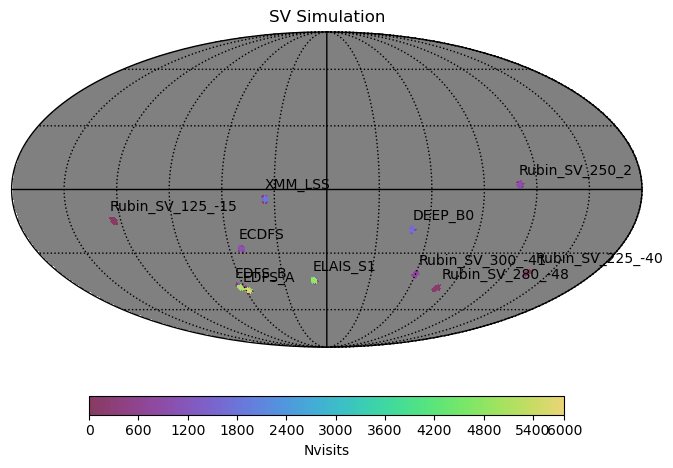

In [24]:
ph = maf.PlotHandler(out_dir=out_dir, thumbnail=False, fig_format='png')
ph.set_metric_bundles([bundle])
plot_dict = {'xlabel': 'Nvisits', 'title': "SV Simulation"}
fig = ph.plot(maf.HealpixSkyMap(), plot_dict)
field_dict = get_sv_fields()
for f in np.unique(visits_np['target']):
    hp.projtext(field_dict[f]['RA'], field_dict[f]['Dec']+5, f, lonlat=True)

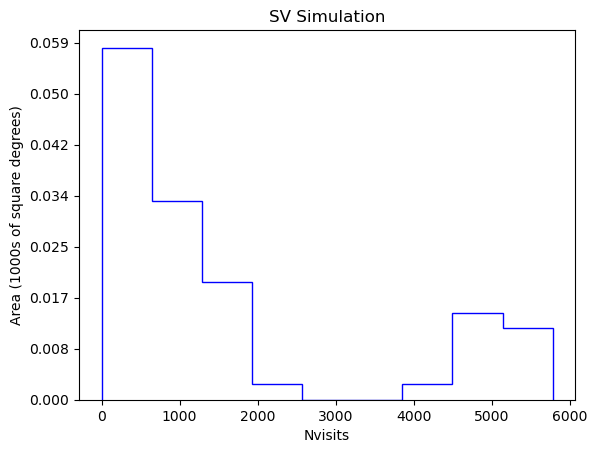

In [28]:
ph = maf.PlotHandler(out_dir=out_dir, thumbnail=False, fig_format='png')
ph.set_metric_bundles([bundle])
plot_dict = {'xlabel': 'Nvisits', 'title': "SV Simulation"}
fig = ph.plot(maf.HealpixHistogram(), plot_dict)